### Preprocessing

Wczytanie danych i importy

In [25]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import utils
import os
import IPython.display as ipd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm

# Ustawienia wykresów
plt.rcParams['figure.figsize'] = (14, 5)

def normalize(x, axis=0):
    """Normalizacja danych do zakresu [0, 1] dla lepszej wizualizacji"""
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

In [26]:




# Load metadata and features.
tracks = utils.load('fma_metadata/tracks.csv')
genres = utils.load('fma_metadata/genres.csv')
features = utils.load('fma_metadata/features.csv')
echonest = utils.load('fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape



((106574, 52), (163, 4), (106574, 518), (13129, 249))

Filtr Wienera

In [27]:
def apply_denoising(y):
    """
    Aplikuje filtr Wienera do sygnału audio w celu redukcji szumu.
    """
    # Filtr Wienera działa lepiej na wygładzaniu, tutaj aplikujemy go z małym oknem
    y_denoised = scipy.signal.wiener(y, noise=None) 
    return y_denoised

Losowy utwór dla gatunku

In [28]:
subset_mask = tracks['set', 'subset'] == 'small'
available_genres = tracks[subset_mask]['track', 'genre_top'].unique()
print(f"Available genres in small: {available_genres}")

Available genres in small: ['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International', 'Electronic', 'Instrumental']
Categories (16, object): ['Blues', 'Classical', 'Country', 'Easy Listening', ..., 'Pop', 'Rock', 'Soul-RnB', 'Spoken']


In [29]:
import os
import random


METADATA_DIR = 'fma_metadata'       
AUDIO_DIR = 'fma_small'             


tracks = utils.load(os.path.join(METADATA_DIR, 'tracks.csv'))


def get_random_track_for_genre(genre_name, subset='small'):
    """
    Zwraca ścieżkę do losowego pliku audio z danego gatunku.
    """
    try:
        
        subset_mask = tracks['set', 'subset'] == subset
        genre_mask = tracks['track', 'genre_top'] == genre_name
        
        candidates = tracks[subset_mask & genre_mask]
        
        if candidates.empty:
            print(f"Nie znaleziono utworów dla gatunku: '{genre_name}' w zbiorze {subset}.")
            available = tracks[subset_mask]['track', 'genre_top'].unique()
            print(f"Dostępne gatunki w {subset}: {available}")
            return None
            

        track_id = random.choice(candidates.index.tolist())
        

        path = utils.get_audio_path(AUDIO_DIR, track_id)
        
        return path, track_id
        
    except Exception as e:
        print(f"Wystąpił błąd: {e}")
        return None




## Wizualizacja

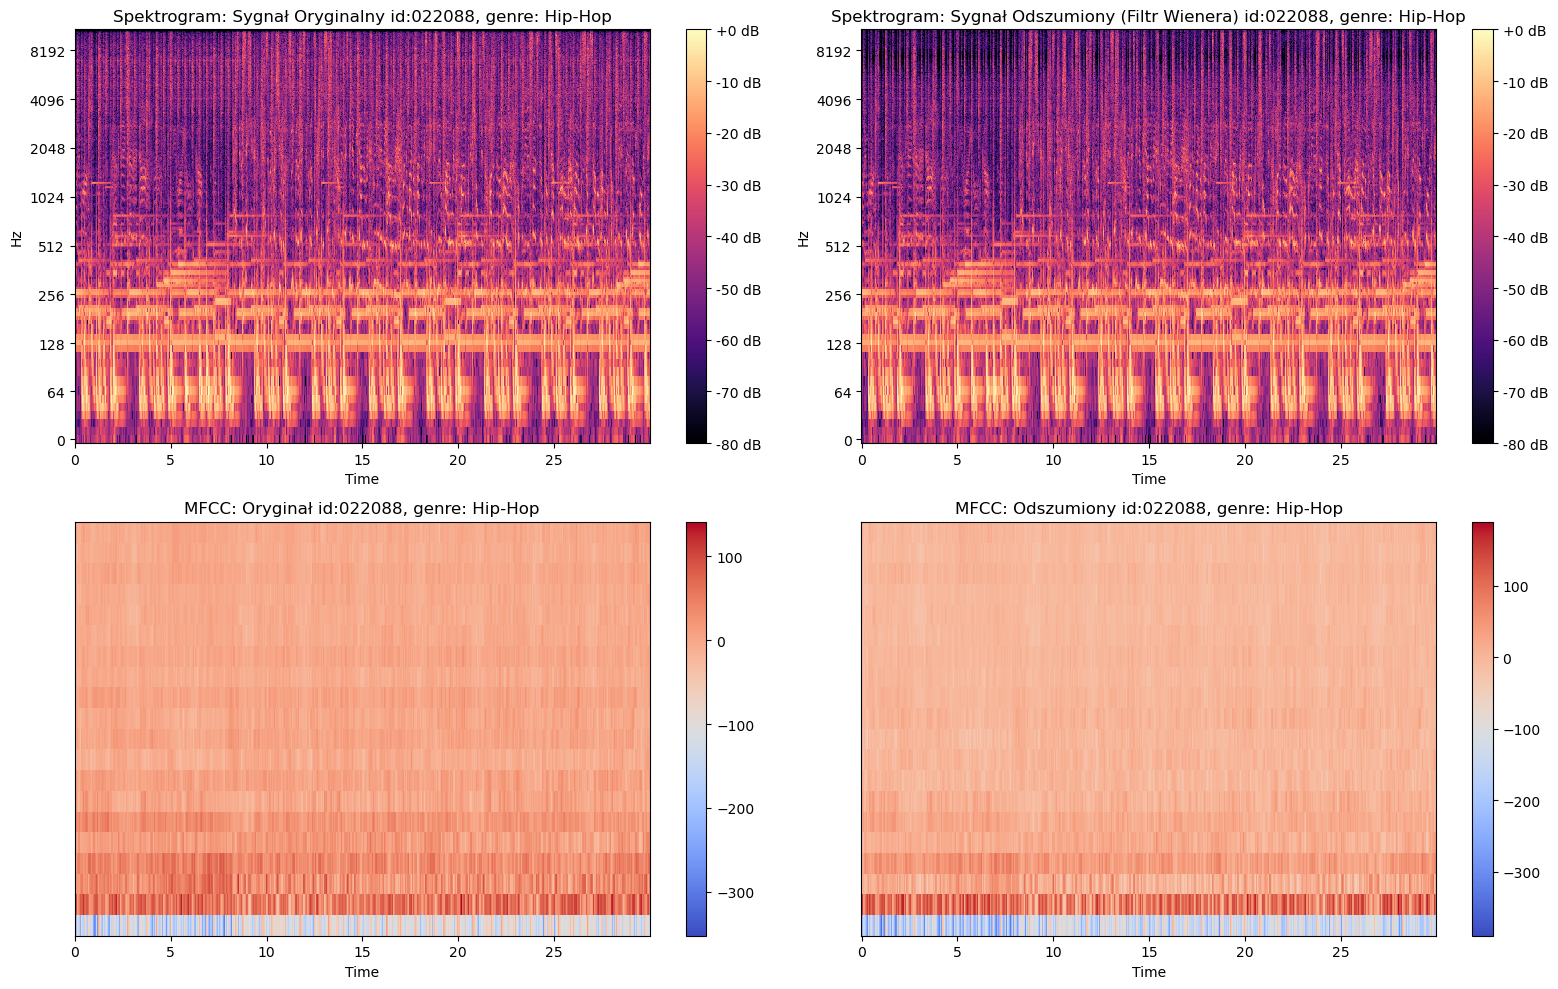

In [40]:

genre = 'Hip-Hop'
audio_path, audio_id = get_random_track_for_genre(genre); 

y, sr = librosa.load(audio_path, duration=30) 

# zastosowanie odszumiania
y_denoised = apply_denoising(y)

# ekstrakcja cech (MFCC) dla obu sygnałów
mfcc_original = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
mfcc_denoised = librosa.feature.mfcc(y=y_denoised, sr=sr, n_mfcc=20)

# wizualizacja porównawcza - Spektrogramy
plt.figure(figsize=(16, 10))

# oryginał
plt.subplot(2, 2, 1)
D_orig = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D_orig, y_axis='log', x_axis='time', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title(f'Spektrogram: Sygnał Oryginalny id:{audio_id:06d}, genre: {genre}')

# odszumiony
plt.subplot(2, 2, 2)
D_denoised = librosa.amplitude_to_db(np.abs(librosa.stft(y_denoised)), ref=np.max)
librosa.display.specshow(D_denoised, y_axis='log', x_axis='time', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title(f'Spektrogram: Sygnał Odszumiony (Filtr Wienera) id:{audio_id:06d}, genre: {genre}')

# wizualizacja porównawcza - MFCC
plt.subplot(2, 2, 3)
librosa.display.specshow(mfcc_original, x_axis='time')
plt.colorbar()
plt.title(f'MFCC: Oryginał id:{audio_id:06d}, genre: {genre}')

plt.subplot(2, 2, 4)
librosa.display.specshow(mfcc_denoised, x_axis='time')
plt.colorbar()
plt.title(f'MFCC: Odszumiony id:{audio_id:06d}, genre: {genre}')

plt.tight_layout()
plt.show()



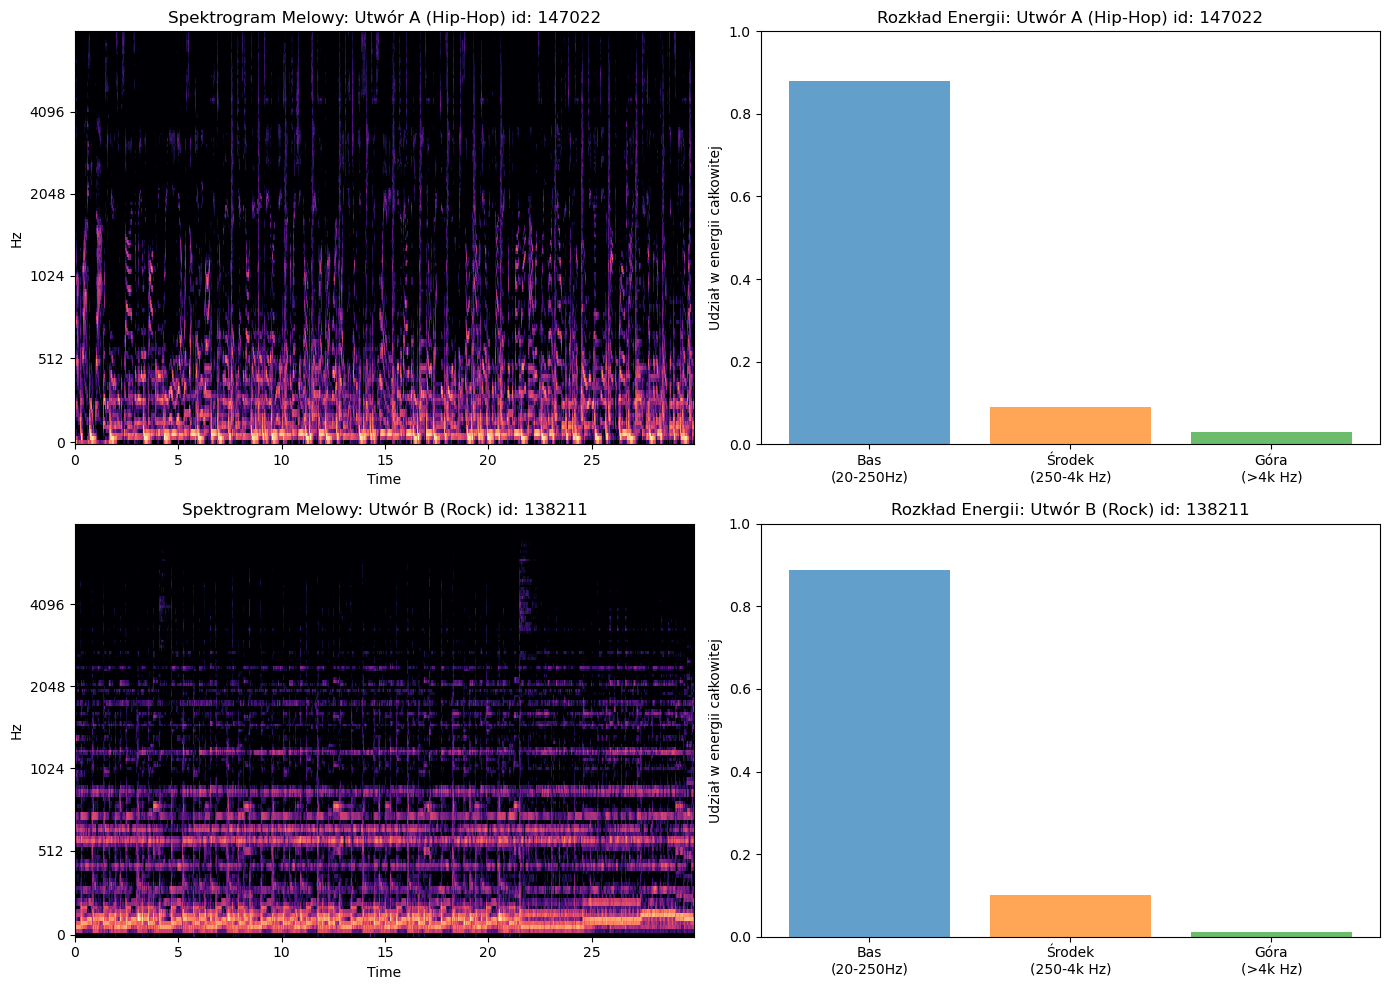

In [41]:
def analyze_frequency_bands(file_path, label, ax_spec, ax_bar):
    """
    Oblicza spektrogram i energię w 3 pasmach (Low, Mid, High).
    """
    # wczytanie
    try:
        y, sr = librosa.load(file_path, duration=30) 
    except Exception as e:
        print(f"Nie można wczytać {file_path}: {e}")
        return

    # spektrogram Melowy (dla wizualizacji tekstury)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    S_dB = librosa.amplitude_to_db(S, ref=np.max)
    
    # rysowanie spektrogramu
    img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=ax_spec)
    ax_spec.set_title(f'Spektrogram Melowy: {label}')
    
    # obliczenie energii w pasmach (na podstawie STFT)
    D = np.abs(librosa.stft(y))
    frequencies = librosa.fft_frequencies(sr=sr)
    
    # Definicja pasm (w Hz)
    # Bas: 20 - 250 Hz
    # Środek: 250 - 4000 Hz
    # Góra: 4000 Hz +
    
    # znajdowanie indeksów pasm
    idx_low = (frequencies >= 20) & (frequencies < 250)
    idx_mid = (frequencies >= 250) & (frequencies < 4000)
    idx_high = (frequencies >= 4000)
    
    # sumowanie energii w pasmach (średnia po czasie)
    energy_low = np.mean(D[idx_low, :])
    energy_mid = np.mean(D[idx_mid, :])
    energy_high = np.mean(D[idx_high, :])
    
    # normalizacja do procentowego udziału (opcjonalne, ale czytelne)
    total_energy = energy_low + energy_mid + energy_high
    energies = [energy_low/total_energy, energy_mid/total_energy, energy_high/total_energy]
    
    # rysowanie wykresu słupkowego
    bands = ['Bas\n(20-250Hz)', 'Środek\n(250-4k Hz)', 'Góra\n(>4k Hz)']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] # Niebieski, Pomarańczowy, Zielony
    ax_bar.bar(bands, energies, color=colors, alpha=0.7)
    ax_bar.set_title(f'Rozkład Energii: {label}')
    ax_bar.set_ylabel('Udział w energii całkowitej')
    ax_bar.set_ylim(0, 1.0) # Skala 0-100%



genre1 = 'Hip-Hop'

track1_path, track1_id = get_random_track_for_genre(genre1) 
track1_label = f'Utwór A ({genre1}) id: {track1_id:06d}'

genre2 = 'Rock'

track2_path, track2_id = get_random_track_for_genre(genre2)
track2_label = f'Utwór B ({genre2}) id: {track2_id:06d}'



fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# analiza utworu 1
analyze_frequency_bands(track1_path, track1_label, ax[0,0], ax[0,1])

# analiza utworu 2
analyze_frequency_bands(track2_path, track2_label, ax[1,0], ax[1,1])

plt.tight_layout()
plt.show()